### Zainstalowanie bibliotek

Potrzebne do użycia funkcji read_excel z biblioteki pandas

In [ ]:
!pip install openpyxl==3.0.0 # for pandas read_excel

     |████████████████████████████████| 172 kB 5.1 MB/s 
  Created wheel for openpyxl: filename=openpyxl-3.0.0-py2.py3-none-any.whl size=241207 sha256=846380257dce51fb7daee021450521f7cd73abccb43584a53c862990a784a76b
  Stored in directory: /root/.cache/pip/wheels/c7/64/ff/ce98f6e1d2701ae8e216c875da62feed2839ac8a3cae0ab8af
Successfully built openpyxl
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9


### Zaimportowanie bibliotek

In [ ]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf

### Wczytanie wierszy i odpowiednich kolumn z plików 

In [ ]:
columns = ['station_id', 'day', 'month', 'year', 'mean temperature [deg F]', 'mean dew point [deg F]', 'mean pressure (sea level) [Pa]', 'mean pressure (station) [Pa]', 'mean visibility [mile]', 'mean wind speed [knot]', 'max wind gust [knot]', 'max temperature [deg F]',
'min temperature [deg F]', 'total precipitation [inch]', 'snow depth [inch]']
train_df = pd.read_excel('data_JA_df_training.xlsx')[columns]
test_df = pd.read_excel('data_JA_df_evaluation.xlsx')[columns]

### Znormalizowanie danych

In [ ]:
columns = ['station_id', 'mean dew point [deg F]', 'mean pressure (sea level) [Pa]', 'mean pressure (station) [Pa]', 'mean visibility [mile]', 'mean wind speed [knot]', 'max wind gust [knot]', 'max temperature [deg F]',
'min temperature [deg F]', 'total precipitation [inch]', 'snow depth [inch]']

train_mean = train_df[columns].mean()
train_std = train_df[columns].std()

test_mean = test_df[columns].mean()
test_std = test_df[columns].std()

train_df[columns] = (train_df[columns] - train_mean) / train_std
test_df[columns] = (test_df[columns] - test_mean) / test_std

### Dodanie kolumny z datą do późniejszego przygotowania sekwencji

In [ ]:
train_df['date'] = train_df.apply(lambda d: datetime.date(day=int(d.day), month=int(d.month), year=int(d.year)), axis=1)
test_df['date'] = test_df.apply(lambda d: datetime.date(day=int(d.day), month=int(d.month), year=int(d.year)), axis=1)

### Pogrupowanie po stacjach

In [ ]:
df_stations_train = train_df.groupby("station_id")
df_stations_test = test_df.groupby("station_id")

print(df_stations_train.size())
print(df_stations_test.size())

station_id
-2.046368    365
-2.025643    365
-1.998009    365
-1.984193    365
-1.977284    365
            ... 
 1.456176    365
 1.476901    364
 1.594343    365
 1.684152    365
 1.704877    365
Length: 90, dtype: int64
station_id
-1.538807    365
-0.943052    365
-0.435307    365
-0.320218    365
-0.313448    365
-0.266059    365
-0.096810    365
 0.708813    365
 1.040539    365
 2.164349    365
dtype: int64


### Utworzenie sekwencji treningowej i testowej

In [ ]:
two_weeks_diff = datetime.timedelta(days = 13) # w sumie 14 dni
st_index = 0
stations_train_value = []
stations_train_label = []
for name, station_train in df_stations_train:
  stations_train_value.append([])
  stations_train_label.append([])
  for index, station_measurement in station_train.iterrows():

    m_station_id = station_measurement.station_id
    m_date_to = station_measurement.date
    m_date_from = m_date_to - two_weeks_diff;

    two_weeks_sequence = station_train[(station_train['date'] >= m_date_from) & (station_train['date'] <= m_date_to)]
    if len(two_weeks_sequence) == 14:
      stations_train_value[st_index].append(two_weeks_sequence[columns])
      stations_train_label[st_index].append(station_measurement['mean temperature [deg F]'])
  st_index += 1

In [ ]:
two_weeks_diff = datetime.timedelta(days = 13) # w sumie 14 dni
st_index = 0
stations_test_value = []
stations_test_label = []
for name, station_train in df_stations_test:
  stations_test_value.append([])
  stations_test_label.append([])
  for index, station_measurement in station_train.iterrows():

    m_station_id = station_measurement.station_id
    m_date_to = station_measurement.date
    m_date_from = m_date_to - two_weeks_diff;

    two_weeks_sequence = station_train[(station_train['date'] >= m_date_from) & (station_train['date'] <= m_date_to)]
    if len(two_weeks_sequence) == 14:
      stations_test_value[st_index].append(two_weeks_sequence[columns])
      stations_test_label[st_index].append(station_measurement['mean temperature [deg F]'])
  st_index += 1

### Zamiana list na numpy array

In [ ]:
train_final_value = np.array(stations_train_value)
train_final_label = np.array(stations_train_label)

print(train_final_value.shape)
print(train_final_label.shape)

for index, row in enumerate(train_final_value):
  train_final_value[index] = np.array(row).astype(np.float32)

for index, row in enumerate(train_final_label):
  train_final_label[index] = np.array(row).astype(np.float32)

print(train_final_value[0][0])
print(train_final_label[0][0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


(90,)
(90,)
[[-2.046368   -1.2029727  -5.103378   -0.63390094 -1.3112237   4.0044494
  -1.3112237  -1.9423287  -1.4938451  -0.21508503 -0.943497  ]
 [-2.046368   -1.2029727  -2.7342894  -0.63390094 -1.7740207   4.0347695
  -1.7740207  -1.8897102  -1.2446393  -0.21508503 -1.3480691 ]
 [-2.046368   -1.5323619  -1.6848946  -0.22162296  0.23143263  0.72986776
   0.23143263 -2.0592585  -1.7140734  -0.21508503  0.4050766 ]
 [-2.046368   -1.4982871  -0.794499   -0.22162296  1.4312764   0.5479465
   1.4312764  -1.9072497  -1.9053243  -0.21508503  1.4539671 ]
 [-2.046368   -1.2143309  -0.8739986  -0.22162296 -1.1226768   3.3677251
  -1.1226768  -1.9306357  -1.9053243  -0.21508503 -0.7786713 ]
 [-2.046368   -1.225689   -0.6990994   0.1656685  -1.6711769   5.005016
  -1.6711769  -1.9306357  -1.2852077  -0.21508503 -1.2581642 ]
 [-2.046368   -1.5948323  -0.25390166  0.34057432 -1.0541143   2.6703606
  -1.0541143  -2.1294162  -1.5981637  -0.21508503 -0.71873474]
 [-2.046368   -1.9015051  -0.3334012

In [ ]:
test_final_value = np.array(stations_test_value)
test_final_label = np.array(stations_test_label)

print(test_final_value.shape)
print(test_final_label.shape)

for index, row in enumerate(test_final_value):
  test_final_value[index] = np.array(row).astype(np.float32)

for index, row in enumerate(test_final_label):
  test_final_label[index] = np.array(row).astype(np.float32)

print(test_final_value[0][0])
print(test_final_label[0][0])

(10, 352, 14, 11)
(10, 352)
[[-1.53880692 -1.3801024  -4.37268448 -0.97868294 -0.08122716  1.02628791
  -0.08122716 -1.87571633 -1.26345658 -0.23250347  0.12184759]
 [-1.53880692 -1.3801024  -2.83865499 -0.46798059  0.46102253 -0.17035951
   0.46102253 -1.82346177 -1.66834009 -0.23250347  0.61039799]
 [-1.53880692 -1.44793189 -1.67215347 -0.079634    1.18402219 -0.20454943
   1.18402219 -1.83507383 -1.81090462 -0.23250347  1.2617985 ]
 [-1.53880692 -1.47054172 -0.69740552  0.24487479  1.18402219 -0.47806886
   1.18402219 -1.83507383 -1.81090462 -0.23250347 -1.56587195]
 [-1.53880692 -1.32923019 -2.29535294  0.24487479  0.87181777  2.49645472
   0.87181777 -1.79443145 -1.63412452 -0.23250347  0.9805119 ]
 [-1.53880692 -1.36314499 -1.99174297 -0.18603033  2.9586575   3.69310212
   2.9586575  -1.79443145 -1.14370239 -0.23250347  2.86069059]
 [-1.53880692 -1.83229935 -0.80926186 -0.18603033  2.9586575   2.08617568
   2.9586575  -1.73056459 -1.77668917 -0.23250347 -1.56587195]
 [-1.53880692

### Połączenie sekwencji z różnych stacji

In [ ]:
train_final_value_concat = np.concatenate(train_final_value)
train_final_label_concat = np.concatenate(train_final_label)
test_final_value_concat = np.concatenate(test_final_value)
test_final_label_concat = np.concatenate(test_final_label)

### Sprawdzenie przykładowych elementów

In [ ]:
print(train_final_value_concat[0])
print(train_final_label_concat[0])

[[-2.046368   -1.2029727  -5.103378   -0.63390094 -1.3112237   4.0044494
  -1.3112237  -1.9423287  -1.4938451  -0.21508503 -0.943497  ]
 [-2.046368   -1.2029727  -2.7342894  -0.63390094 -1.7740207   4.0347695
  -1.7740207  -1.8897102  -1.2446393  -0.21508503 -1.3480691 ]
 [-2.046368   -1.5323619  -1.6848946  -0.22162296  0.23143263  0.72986776
   0.23143263 -2.0592585  -1.7140734  -0.21508503  0.4050766 ]
 [-2.046368   -1.4982871  -0.794499   -0.22162296  1.4312764   0.5479465
   1.4312764  -1.9072497  -1.9053243  -0.21508503  1.4539671 ]
 [-2.046368   -1.2143309  -0.8739986  -0.22162296 -1.1226768   3.3677251
  -1.1226768  -1.9306357  -1.9053243  -0.21508503 -0.7786713 ]
 [-2.046368   -1.225689   -0.6990994   0.1656685  -1.6711769   5.005016
  -1.6711769  -1.9306357  -1.2852077  -0.21508503 -1.2581642 ]
 [-2.046368   -1.5948323  -0.25390166  0.34057432 -1.0541143   2.6703606
  -1.0541143  -2.1294162  -1.5981637  -0.21508503 -0.71873474]
 [-2.046368   -1.9015051  -0.33340126  0.3093411

In [ ]:
print(test_final_value_concat[0])
print(test_final_label_concat[0])

[[-1.53880692 -1.3801024  -4.37268448 -0.97868294 -0.08122716  1.02628791
  -0.08122716 -1.87571633 -1.26345658 -0.23250347  0.12184759]
 [-1.53880692 -1.3801024  -2.83865499 -0.46798059  0.46102253 -0.17035951
   0.46102253 -1.82346177 -1.66834009 -0.23250347  0.61039799]
 [-1.53880692 -1.44793189 -1.67215347 -0.079634    1.18402219 -0.20454943
   1.18402219 -1.83507383 -1.81090462 -0.23250347  1.2617985 ]
 [-1.53880692 -1.47054172 -0.69740552  0.24487479  1.18402219 -0.47806886
   1.18402219 -1.83507383 -1.81090462 -0.23250347 -1.56587195]
 [-1.53880692 -1.32923019 -2.29535294  0.24487479  0.87181777  2.49645472
   0.87181777 -1.79443145 -1.63412452 -0.23250347  0.9805119 ]
 [-1.53880692 -1.36314499 -1.99174297 -0.18603033  2.9586575   3.69310212
   2.9586575  -1.79443145 -1.14370239 -0.23250347  2.86069059]
 [-1.53880692 -1.83229935 -0.80926186 -0.18603033  2.9586575   2.08617568
   2.9586575  -1.73056459 -1.77668917 -0.23250347 -1.56587195]
 [-1.53880692 -1.77012229 -0.37781605  0.

### Zbudowanie modelu

In [ ]:
lstm_model_lr = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='relu')
])

In [ ]:
MAX_EPOCHS = 30

early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_squared_error', min_delta=0, patience=10, verbose=2, mode='auto',
    baseline=None, restore_best_weights=True)

lstm_model_lr.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=[tf.metrics.MeanSquaredError()],
)

history = lstm_model_lr.fit(train_final_value_concat, train_final_label_concat, validation_split=0.2, epochs=MAX_EPOCHS, callbacks=[early_stopping])

Epoch 1/30
792/792 [==============================] - 118s 142ms/step - loss: 349.8621 - mean_squared_error: 349.8621 - val_loss: 52.9081 - val_mean_squared_error: 52.9081
Epoch 2/30
792/792 [==============================] - 112s 142ms/step - loss: 28.2253 - mean_squared_error: 28.2253 - val_loss: 21.4683 - val_mean_squared_error: 21.4683
Epoch 3/30
792/792 [==============================] - 112s 142ms/step - loss: 16.8832 - mean_squared_error: 16.8832 - val_loss: 9.7739 - val_mean_squared_error: 9.7739
Epoch 4/30
792/792 [==============================] - 113s 142ms/step - loss: 9.7172 - mean_squared_error: 9.7172 - val_loss: 6.1700 - val_mean_squared_error: 6.1700
Epoch 5/30
792/792 [==============================] - 111s 140ms/step - loss: 7.7923 - mean_squared_error: 7.7923 - val_loss: 5.3295 - val_mean_squared_error: 5.3295
Epoch 6/30
792/792 [==============================] - 114s 144ms/step - loss: 7.0558 - mean_squared_error: 7.0558 - val_loss: 8.2425 - val_mean_squared_error:

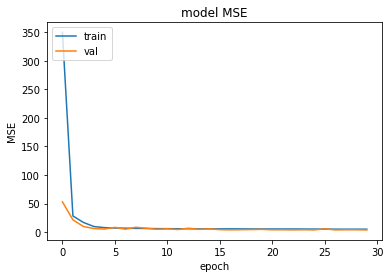

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Ewaluacja

In [ ]:
lstm_model_lr.evaluate(test_final_value_concat, test_final_label_concat)

110/110 [==============================] - 2s 14ms/step - loss: 4.9913 - mean_squared_error: 4.9913


[4.991268157958984, 4.991268157958984]

### Wyświetlenie wykresu

In [ ]:
predictions = lstm_model_lr.predict(test_final_value_concat, batch_size = 1)

start = 0
end = 200

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(test_final_label_concat[start:end], 'b', predictions[start:end], 'g')